# RECALAGE
# Premiers pas en *SimpleITK*

## Les différentes composants 

<img src="./recalage.png" style="width:700px"/><br><br>



Recaler des images dans *SimpleITK* nécessite de mettre en place plusieurs étapes:
1. définir un *index de mesure* pour estimer la qualité du recalage
2. *optimiser* le recalage par itérations successives pour obtenir la meilleure *transformation spatiale*
3. ré-échantillonner les images recalées suite à la transformation géométrique. 

Ces étapes clés peuvent être réalisées de plusieures façons au sein de *SimpleITK* à l'aide de méthodes disponibles dans la classe <a href="http://www.itk.org/SimpleITKDoxygen/html/classitk_1_1simple_1_1ImageRegistrationMethod.html">ImageRegistrationMethod</a>.
Actuellement,plusieurs choix possibles par catégorie:
### Optimisation
Différentes méthodes disponibles via les méthodes SetOptimizerAsX()
<ul>
  <li>
  <a href="http://www.itk.org/Doxygen/html/classitk_1_1ExhaustiveOptimizerv4.html">Exhaustive</a>
  </li>
  <li>
  <a href="http://www.itk.org/Doxygen/html/classitk_1_1AmoebaOptimizerv4.html">Nelder-Mead downhill simplex</a>, a.k.a. Amoeba.
  </li>
  <li>
  Plusieurs variantes de descente de gradient :
  <ul>
    <li>
    <a href="http://www.itk.org/Doxygen/html/classitk_1_1GradientDescentOptimizerv4Template.html">GradientDescent</a>
    </li>
    <li>
    <a href="http://www.itk.org/Doxygen/html/classitk_1_1GradientDescentLineSearchOptimizerv4Template.html">GradientDescentLineSearch</a>
    </li>
    <li>
    <a href="http://www.itk.org/Doxygen/html/classitk_1_1RegularStepGradientDescentOptimizerv4.html">RegularStepGradientDescent</a>
    </li>
  </ul>
  </li>
  <li>
    <a href="http://www.itk.org/Doxygen/html/classitk_1_1ConjugateGradientLineSearchOptimizerv4Template.html">ConjugateGradientLineSearch</a> 
  </li>
  <li>
  <a href="http://www.itk.org/Doxygen/html/classitk_1_1LBFGSBOptimizerv4.html">L-BFGS-B</a> (Limited memory Broyden,  Fletcher, Goldfarb, Shannon-Bound Constrained) - support de contraintes simples ($l\leq x \leq u$)  
  </li>
</ul>

### Mesure de similarité
Différents indices de similitude à travers les fonctions SetMetricAsX():

<ul>
  <li>
  <a href="http://www.itk.org/Doxygen/html/classitk_1_1MeanSquaresImageToImageMetricv4.html">MeanSquares</a>
  </li>
  <li>
  <a href="http://www.itk.org/Doxygen/html/classitk_1_1DemonsImageToImageMetricv4.html">Demons</a>
  </li>
  <li>
  <a href="http://www.itk.org/Doxygen/html/classitk_1_1CorrelationImageToImageMetricv4.html">Correlation</a>
  </li>
  <li>
  <a href="http://www.itk.org/Doxygen/html/classitk_1_1ANTSNeighborhoodCorrelationImageToImageMetricv4.html">ANTSNeighborhoodCorrelation</a>
  </li>
  <li>
  <a href="http://www.itk.org/Doxygen/html/classitk_1_1JointHistogramMutualInformationImageToImageMetricv4.html">JointHistogramMutualInformation</a>
  </li>
  <li>
  <a href="http://www.itk.org/Doxygen/html/classitk_1_1MattesMutualInformationImageToImageMetricv4.html">MattesMutualInformation</a>
  </li>
</ul>

### Interpolateurs
Différents systèmes d'interpolation à travers la fonction SetInterpolator() qui reçoit en argument une des  
<a href="http://www.itk.org/SimpleITKDoxygen/html/namespaceitk_1_1simple.html#a7cb1ef8bd02c669c02ea2f9f5aa374e5"> énumérations suivantes</a> :
<ul>
<li> sitkNearestNeighbor </li>
<li> sitkLinear </li>
<li> sitkBSpline </li>
<li> sitkGaussian </li>
<li> sitkHammingWindowedSinc </li>
<li> sitkCosineWindowedSinc </li>
<li> sitkWelchWindowedSinc </li>
<li> sitkLanczosWindowedSinc </li>
<li> sitkBlackmanWindowedSinc </li>
</ul>
___

## Chargement des images

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import clear_output
from myshow import myshow

#callback invoked by the ipython interact method for scrolling and modifying the alpha blending
#of an image stack of two images that occupy the same physical space. 
def display_images_with_alpha(image_z, alpha, fixed, moving):
    img = (1.0 - alpha)*fixed[:,:,image_z] + alpha*moving[:,:,image_z] 
    plt.imshow(sitk.GetArrayFromImage(img),cmap=plt.cm.Greys_r);
    plt.axis('off')
    
    
#callback invoked when the StartEvent happens, sets up our new data
def start_plot():
    global metric_values, multires_iterations
    
    metric_values = []
    multires_iterations = []

#callback invoked when the EndEvent happens, do cleanup of data and figure
def end_plot():
    global metric_values, multires_iterations
    
    del metric_values
    del multires_iterations
    #close figure, we don't want to get a duplicate of the plot latter on
    plt.close()

#callback invoked when the IterationEvent happens, update our data and display new figure    
def plot_values(registration_method):
    global metric_values, multires_iterations
    
    metric_values.append(registration_method.GetMetricValue())                                       
    #clear the output area (wait=True, to reduce flickering), and plot current data
    clear_output(wait=True)
    #plot the similarity metric values
    plt.plot(metric_values, 'r')
    plt.plot(multires_iterations, [metric_values[index] for index in multires_iterations], 'b*')
    plt.xlabel('Iteration Number',fontsize=12)
    plt.ylabel('Metric Value',fontsize=12)
    plt.show()
    
#callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the 
#metric_values list. 
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))        

On charge et on affiche l'image fixe.

In [2]:
import SimpleITK as sitk
fixed_DP = sitk.ReadImage("ManualRegistrationExample_fixed.nrrd")

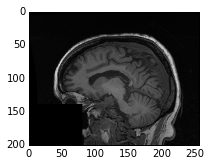

None

In [3]:
myshow(fixed_DP)

On charge et on affiche l'image mobile.

In [4]:
moving_T2 = sitk.ReadImage("ManualRegistrationExample_moving.nrrd")

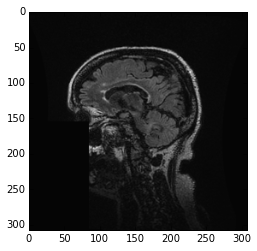

None

In [5]:
myshow(moving_T2);

## Transformation initiale
La fonction `CenteredTransformInitializer` aligne les centres des 2 volumes et fixe le centre de rotation sur le centre de l'image fixe.

In [7]:
initial_transform = sitk.CenteredTransformInitializer(
                            sitk.Cast(fixed_DP,moving_T2.GetPixelIDValue()), 
                            moving_T2, 
                            sitk.Euler3DTransform(), 
                            sitk.CenteredTransformInitializerFilter.MOMENTS)

# Jouons un peu avec les caractéristiques "objet" de sitk

resample = sitk.ResampleImageFilter()
resample.SetReferenceImage(fixed_DP)
    
# SimpleITK dispose de plusieurs types d'interpolation, 
# on choisit la plus simple.     
resample.SetInterpolator(sitk.sitkLinear)  
resample.SetTransform(initial_transform)
moving_T2_resample = resample.Execute(moving_T2)

# On peut tout aussi bien faire la même opération sous forme "fonctionnelle"
#moving_T2_resample = sitk.Resample(
#                   moving_T2, fixed_DP, initial_transform,
#                   sitk.sitkLinear, 0.0, moving_T2.GetPixelIDValue())

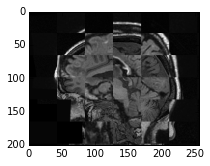

None

In [8]:
myshow(sitk.CheckerBoard(sitk.RescaleIntensity(fixed_DP),
                         sitk.RescaleIntensity(moving_T2_resample), 
                         checkerPattern=[6,6,1]))

## Le recalage

Nous avons choisi les paramètres suivants pour procéder au recalage des 2 images précédentes.

* La __métrique__ est l'information mutuelle `MattesMutualInformation`
    - nombre de cellules des histogrammes : 50
    - stratégie d'échantillonnage : aléatoire
    - Pourcentage d'échantillonnage : 1%
* L'interpolateur : 
    - linéaire
* L'optimiseur : 
    - la descente de gradient
    - nombre d'itération maximale : 100
    - coefficient multiplicateur du gradient : 1

In [9]:
registration_method = sitk.ImageRegistrationMethod()

registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.01)

registration_method.SetInterpolator(sitk.sitkLinear)

registration_method.SetOptimizerAsGradientDescent(learningRate=1, numberOfIterations=100)

'''
PARAMETRE CRITIQUE: D'après la documentation :
http://www.itk.org/SimpleITKDoxygen/html/classitk_1_1simple_1_1ImageRegistrationMethod.html#a53934282121e152d37781ffa5224ec5f
                Estimating scales of transform parameters a step sizes, 
                from the maximum voxel shift in physical space caused by a parameter change
'''
registration_method.SetOptimizerScalesFromPhysicalShift() 

registration_method.SetInitialTransform(initial_transform, inPlace=False)

registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
registration_method.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(registration_method))

0

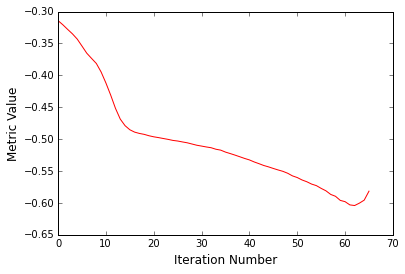

In [10]:
final_transform_v1 = registration_method.Execute(
                                sitk.Cast(fixed_DP, sitk.sitkFloat32), 
                                sitk.Cast(moving_T2, sitk.sitkFloat32))

In [11]:
resample.SetTransform(final_transform_v1)

<SimpleITK.SimpleITK.ResampleImageFilter; proxy of <Swig Object of type 'itk::simple::ResampleImageFilter::Self *' at 0x11e0865a0> >

In [12]:
moving_T2_resample_2 = resample.Execute(moving_T2)

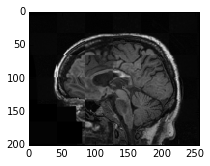

None

In [13]:
myshow(sitk.CheckerBoard(sitk.RescaleIntensity(fixed_DP), 
                         sitk.RescaleIntensity(moving_T2_resample_2),
                         checkerPattern=[6,6,1]))

In [14]:
print u"Condition d'arrêt de l'optimiseur {0}"\
        .format(registration_method.GetOptimizerStopConditionDescription())
#print final_transform_v1

Condition d'arrêt de l'optimiseur GradientDescentOptimizerv4Template: Convergence checker passed at iteration 66.


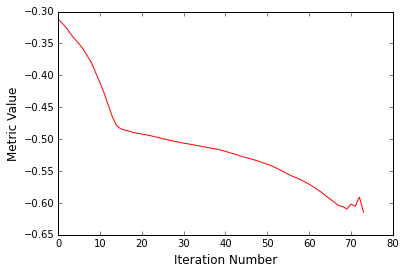

In [10]:
registration_method_2 = sitk.ImageRegistrationMethod()
registration_method_2.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
registration_method_2.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method_2.SetMetricSamplingPercentage(0.01)
registration_method_2.SetInterpolator(sitk.sitkLinear)
registration_method_2.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100)
registration_method_2.SetOptimizerScalesFromPhysicalShift()

# Set the initial moving and optimized transforms.
optimized_transform = sitk.Euler3DTransform()    
registration_method_2.SetMovingInitialTransform(initial_transform)
registration_method_2.SetInitialTransform(optimized_transform)

registration_method_2.AddCommand(sitk.sitkStartEvent, start_plot)
registration_method_2.AddCommand(sitk.sitkEndEvent, end_plot)
registration_method_2.AddCommand(sitk.sitkIterationEvent, 
                               lambda: plot_values(registration_method_2))

registration_method_2.Execute(sitk.Cast(fixed_DP, sitk.sitkFloat32), 
                            sitk.Cast(moving_T2, sitk.sitkFloat32))

# Need to compose the transformations after registration.
final_transform_v11 = sitk.Transform(optimized_transform)
final_transform_v11.AddTransform(initial_transform)
resample.SetTransform(final_transform_v11)
moving_T2_resample_3 = resample.Execute(moving_T2)

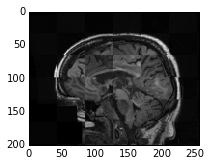

None

In [11]:
myshow(sitk.CheckerBoard(sitk.RescaleIntensity(fixed_DP), 
                         sitk.RescaleIntensity(moving_T2_resample_3),
                         checkerPattern=[6,6,1]))

In [12]:
print u"Condition d'arrêt de l'optimiseur {0}"\
        .format(registration_method_2.GetOptimizerStopConditionDescription())
#print final_transform_v11.GetInverse()

Condition d'arrêt de l'optimiseur GradientDescentOptimizerv4Template: Convergence checker passed at iteration 74.


L'exemple suivant montre comment accélérer la convergence en utilisant une approche multi-echelle.

In [15]:
registration_method_3 = sitk.ImageRegistrationMethod()

registration_method_3.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
registration_method_3.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method_3.SetMetricSamplingPercentage(0.01)

registration_method_3.SetInterpolator(sitk.sitkLinear)
registration_method_3.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100) #, estimateLearningRate=registration_method.EachIteration)
registration_method_3.SetOptimizerScalesFromPhysicalShift() 

final_transform_v2 = sitk.Euler3DTransform(initial_transform)
registration_method_3.SetInitialTransform(final_transform_v2)
registration_method_3.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method_3.SetSmoothingSigmasPerLevel(smoothingSigmas = [2,1,0])
registration_method_3.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

#registration_method.AddCommand(sitk.sitkStartEvent, registration_callbacks.metric_start_plot)
#registration_method.AddCommand(sitk.sitkEndEvent, registration_callbacks.metric_end_plot)
#registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, 
#                               registration_callbacks.metric_update_multires_iterations) 
#registration_method.AddCommand(sitk.sitkIterationEvent, 
#                               lambda: registration_callbacks.metric_plot_values(registration_method))

registration_method_3.Execute(sitk.Cast(fixed_DP, sitk.sitkFloat32), 
                            sitk.Cast(moving_T2, sitk.sitkFloat32))


resample.SetTransform(final_transform_v2)
moving_T2_resample_4 = resample.Execute(moving_T2)

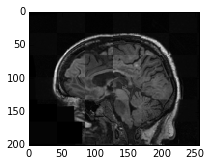

None

In [16]:
myshow(sitk.CheckerBoard(sitk.RescaleIntensity(fixed_DP), 
                         sitk.RescaleIntensity(moving_T2_resample_4),
                         checkerPattern=[6,6,1]))

La convergence est donc plus rapide avec une approche multi-echelle.

In [17]:
print u"Condition d'arrêt de l'optimiseur {0}"\
        .format(registration_method_3.GetOptimizerStopConditionDescription())
#print final_transform_v2    

Condition d'arrêt de l'optimiseur GradientDescentOptimizerv4Template: Convergence checker passed at iteration 9.
